# Computer Tomography

## Introduction

In this notebook we will inspect a CT medical image. We will focus on the following activities:

* Calculating the density of bone from DICOM metadata
* Segmentation
* Filtering
* 3D rendering

## Image Formation

Computer Tomography is the generalized term used for tomographic images obtained using X-Rays which pass through the patient. The image is formed by the anti-scattered light that reaches the detector and is then converted into light. When the X-rays strike the detector they release electrons that are trapped and converted into light (scintillator). For digital detectors we then convert this light into electronic signals that are acquired to form an image.

The image pixels are formed through a "negative" principle since X-rays will reach the detector only when not absorbed by the body. The image is coded with an intensity value that is directly proportional to the absorption and this relative intensity is what is stored in a DICOM file. These units will not be a physical characteristic of the body but a relative unit defined to use the maximum dynamic of the storage space. We can nevertheless rescale the image to obtain the density using conversion to Hounsfield Units (HU). Hounsfield units is a standardized measurement system that is based on the attenuation coefficient of a measured medium, air, and water. The HU gives us a measurement of bone density. The HU is defined as:

$$HU=1000 \frac{\mu - \mu_{water}}{\mu_{water}-\mu_{air}}$$

where $\mu$ is the measured attenuation of the beam in the medium, $\mu_{water}$ and $\mu_{air}$ are the attenuation in water and air at standard atmospheric pressure and temperature. 

In the DICOM file the intensity is stored using a linear relationship between the measured attenuation and its equivalent HU unit and the conversion can be performed with a linear equation:

$$HU=m \times intensity + b$$

where $m$ is a slope stored in the metadata **RescaleSlope** and $b$ is stored in **RescaleIntercept**

We will implement below a conversion from the image pixels in a CT image into HU.


Note: there are 185 files provided for multiple slices of this image. We will work with image 100.


**IMPORTANT NOTE: IF RUNNING THE NOTEBOOK IN AZURE NOTEBOOKS, MAKE SURE YOU ARE USING A PYTHON 3 KERNEL**

In [14]:
!pip install pydicom
!pip install opencv-python

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 208
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113619.2.55.3.1284421438.720.1212483672.467.100
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.840.113619.6.218
(0002, 0013) Implementation Version Name         SH: 'AW4_4_04_05_EXT_'
(0002, 0016) Source Application Entity Title     AE: 'ct3s_oc0'
-------------------------------------------------
(0008, 0000) Group Length                        UL: 566
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '20080603'
(0008, 0013) Instance Creation Time  

/tmp/ipykernel_120/3904621407.py:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(Rows, Columns, np.flipud(ArrayDicom[:, :]))


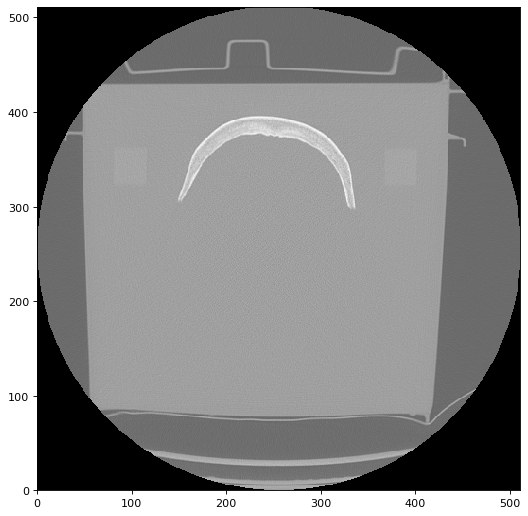

In [15]:
# As usual we will have the magic command for figures inline, but you can use interactive nbagg if you prefer
%matplotlib inline

# And we will start by importing the numerical and ploting packages
import numpy as np
import matplotlib.pyplot as plt

# As well as the DICOM package
import pydicom

# Get file
RefDs = pydicom.read_file('Source Files/CT_DICOMs/im100')
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns))
# Then initialize in zeros an array
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
# Finally we had already read the file and we have the image information in the pixel_array (final field)
ArrayDicom[:,:]=RefDs.pixel_array
# Some rendering tools here to set the size of that image to a specific value dpi and equal axis or square image as well
# as work with grayscale
fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='b')
plt.axes().set_aspect('equal') #this makes the image square
plt.set_cmap(plt.gray()) #grayscale
# Colormesh will require a horizontal and vertical axes
Rows=np.arange(RefDs.Rows)
Columns=np.arange(RefDs.Columns)
# This is the actual rendering
plt.pcolormesh(Rows, Columns, np.flipud(ArrayDicom[:, :]))

# And we will inspect the metadata here
print(RefDs)

### Activity 1 - Inspect the metadata and the rendered image and answer: 

#### 1) What is the model of the CT scanner used? 
#### 2) When was this image taken? 
#### 3) What is the slice thickness for this image? 
#### 4) This image is made from a phantom that is submerged in a plastic container, what anatomical part is the phantom of?



## Image orientation and position
* One of the most important features of the DICOM standard is the information on spatial localization
* The standard provides mechanisms to orient the images

| $~$ | $~$ | |
|:---: |:---:|:--- |
| <img src="Figures/PS3.17_A-1.svg" width=250> | <span style="font-size:1.3em;"> In DICOM, a "LPS" convention is used to <br>give a sense to the orientation <br><ul><li> L - Left is positive, Right is negative</li> <li> P - Posterior is positive, Anterior is negative</li><li>S - Superior is positive , Inferior is negative</li></ul> 
    
<span style="font-size:0.5em;"> (NEMA DICOM Standard - current edition, part 17, chapter A. http://dicom.nema.org/medical/dicom/current/output/html/part17.html#chapter_A.)
 </span> 

* In a DICOM image, the position of a "pixel" can be otained via the pixel size, orientation and positition information stored in the **PixelSpacing**, **ImageOrientationPatient** and **ImagePositionPatient** metadata fields, respectively.
  * **PixelSpacing** is a **two-value** vector that indicates the distance between the center of each pixel for each "row" and "column" in the image
  * **ImageOrientationPatient** is **6-value vector**, often called a "cosine" vector, that tells how the row and column of an image are oriented in the space, starting from the pixel at the "top-left" corner of the raw image
  * **ImagePositionPatient** is a **3-value vector** indicating the position of the of the "top-left" corner of the raw image

The most common image orientations are defined as:
* **Axial** (transverse plane) divides the image into head and feet sections (main "human" axis)
* **Sagittal** (longitudinal plane) divides the image into left and right sections
* **Coronal** (frontal plane) divides the image into ventral and dorsal sections

| $~$ | $~$ | |
|:---: |:---:|:--- |
| <img src="Figures/PS3.17_A-1.svg" width=200> | <span style="font-size:1.3em;"> L - Left is positive, Right is negative</li> <li> P - Posterior is positive, Anterior is negative</li><li>S - Superior is positive , Inferior is negative</li></ul> 

We will inspect a series of CT images of a knee and browse through them to determine by observation the orientation and the axes of the image. 

The following cell is a function to browse through the images. We will only run it without inspecting the code.

In [25]:
from ipywidgets import Button, HBox, VBox, GridBox, Layout, ButtonStyle, Label, Dropdown, IntSlider, interact, Checkbox,interactive
import ipywidgets

import glob
import pandas as pd
import os
class DicomView(object):
    def __init__(self,PathDicom='Source Files/CT_DICOMs/series-000001'):
        self.Files=glob.glob(PathDicom +os.sep+'*.dcm')
        self.Files.sort()
        self.table=ipywidgets.HTML(value="")
        self.table2=ipywidgets.HTML(value="")
        
        P=np.zeros((4,0))
        for LF in [self.Files[0],self.Files[-1]]:
            RefDs=pydicom.read_file(LF)
            ImagePos=np.array(RefDs.ImagePositionPatient)
            ImageOr=np.array(RefDs.ImageOrientationPatient)
            PixelSize=np.array(RefDs.PixelSpacing)

            Rows=np.arange(int(RefDs.Rows))
            Cols=np.arange(int(RefDs.Columns))
            CC,RR=np.meshgrid(Cols,Rows)
            Cr=CC.flatten()
            Rr=RR.flatten()

            C=np.zeros((4,len(Cr)))
            C[0,:]=Cr
            C[1,:]=Rr
            C[3,:]=1


            M=np.zeros((4,4))
            M[0:3,0]=ImageOr[:3]*PixelSize[1]
            M[0:3,1]=ImageOr[3:]*PixelSize[0]
            M[0:3,3]=ImagePos
            M[3,3]=1

            P=np.hstack((P,np.dot(M,C)))
        self.LowLimit=P.min(axis=1)[0:3]
        self.UpLimit=P.max(axis=1)[0:3]
        

    def _ShowDataTable(self,ImageNumber=12):
        RefDs=pydicom.read_file(self.Files[ImageNumber])
        fig=plt.figure(figsize=(5,5))
        
        plt.imshow((RefDs.pixel_array),cmap=plt.cm.gray)
        html_table = '<table><thead>'
        
        for col in ['field','value']:
            html_table += '<br><br><th>'+col+'</th>'
        html_table += '</thead><tbody>'
        for row in ['PixelSpacing','ImagePositionPatient','ImageOrientationPatient']:
            html_table += '<tr>'
            html_table += '<td>'+row+'&nbsp&nbsp</td>'
            html_table += '<td>'+(eval('np.array2string(np.where(np.array(RefDs.'+row+')==0,0,np.array(RefDs.'+row+')),precision=2)')) +'</td>'
            html_table += '</tr>'
        html_table += '</tbody></table>'
        self.table.value = html_table
        
        
    def _ShowDataPixelInfo(self,ImageNumber=12,Row=0,Col=0):
        RefDs=pydicom.read_file(self.Files[ImageNumber])
        fig=plt.figure(figsize=(5,5))
        
        plt.imshow((RefDs.pixel_array),cmap=plt.cm.gray)
        plt.plot(Col,Row,'+',color='r',markersize=15)
        
        ImagePos=np.array(RefDs.ImagePositionPatient)
        ImageOr=np.array(RefDs.ImageOrientationPatient)
        PixelSize=np.array(RefDs.PixelSpacing)
        
        M=np.zeros((4,4))
        C=np.array([Col, Row,0,1]).reshape((4,1))
        M[0:3,0]=ImageOr[:3]*PixelSize[1]
        M[0:3,1]=ImageOr[3:]*PixelSize[0]
        M[0:3,3]=ImagePos
        M[3,3]=1
        P=np.dot(M,C)
       
        html_table = '<table><thead>'
        
        for col in ['field','value']:
            html_table += '<br><br><th>'+col+'</th>'
        html_table += '</thead><tbody>'
        for row in ['PixelSpacing','ImagePositionPatient','ImageOrientationPatient']:
            html_table += '<tr>'
            html_table += '<td>'+row+'&nbsp&nbsp</td>'
            html_table += '<td>'+(eval('np.array2string(np.where(np.array(RefDs.'+row+')==0,0,np.array(RefDs.'+row+')),precision=2)')) +'</td>'
            html_table += '</tr>'
            
        html_table += '<tr>'
        html_table += '<td><span style="color:red"> Left: </span></td>'
        html_table += '<td><span style="color:red"> '+ '%3.2f' %(P[0]) +'</span> </td>'
        html_table += '</tr>'
        
        html_table += '<tr>'
        html_table += '<td><span style="color:green"> Posterior: </span></td>'
        html_table += '<td><span style="color:green"> '+ '%3.2f' %(P[1]) +'</span> </td>'
        html_table += '</tr>'
        
        html_table += '<tr>'
        html_table += '<td><span style="color:blue"> Superior: </span></td>'
        html_table += '<td><span style="color:blue"> '+ '%3.2f' %(P[2]) +'</span> </td>'
        html_table += '</tr>'
        html_table += '</tbody></table>'
        self.table2.value = html_table
        

    def _Show3D(self,ImageNumber=12,alpha=30.,beta=60.):
        RefDs=pydicom.read_file(self.Files[ImageNumber])
        ImagePos=np.array(RefDs.ImagePositionPatient)
        ImageOr=np.array(RefDs.ImageOrientationPatient)
        PixelSize=np.array(RefDs.PixelSpacing)
        Rows=np.arange(int(RefDs.Rows))
        Cols=np.arange(int(RefDs.Columns))
        CC,RR=np.meshgrid(Cols,Rows)
        Cr=CC.flatten()
        Rr=RR.flatten()
        
        C=np.zeros((4,len(Cr)))
        C[0,:]=Cr
        C[1,:]=Rr
        C[3,:]=1
        
        
        M=np.zeros((4,4))
        M[0:3,0]=ImageOr[:3]*PixelSize[1]
        M[0:3,1]=ImageOr[3:]*PixelSize[0]
        M[0:3,3]=ImagePos
        M[3,3]=1
        P=np.dot(M,C)
        XX=P[0,:].reshape(CC.shape)
        YY=P[1,:].reshape(CC.shape)
        ZZ=P[2,:].reshape(CC.shape)
        plt3d = plt.figure(figsize=(6,6)).gca(projection='3d')
        plt3d.plot_surface(XX,YY,ZZ, 
                   facecolors=plt.cm.gray(RefDs.pixel_array/RefDs.pixel_array.max()),
                   linewidth=0, antialiased=True, shade=False
                    )
        plt3d.set_xlim(self.LowLimit[0],self.UpLimit[0])
        plt3d.set_ylim(self.LowLimit[1],self.UpLimit[2])
        plt3d.set_zlim(self.LowLimit[2],self.UpLimit[2])
        plt3d.view_init(alpha, beta)
        plt3d.set_xlabel('R $\leftrightarrow$ L')
        plt3d.set_ylabel('P $\leftrightarrow$ A')
        plt3d.set_zlabel('I $\leftrightarrow$ S')
        
        
    def ShowDicomTable(self):
        Sel=IntSlider(min=0,max=len(self.Files)-1,
                    value=0,
                    description='# image',
                    disabled=False,
                    continuous_update=False,
                    layout=Layout(width='350px')
                    )

        g=interactive(self._ShowDataTable,ImageNumber=Sel)
        h=HBox([g,self.table])
        display(h)
        
    def ShowDicomPixel(self):
        Sel=IntSlider(min=0,max=len(self.Files)-1,
                    value=0,
                    description='# image',
                    disabled=False,
                    continuous_update=False,
                    layout=Layout(width='350px')
                    )
        RefDs=pydicom.read_file(self.Files[0])
        
        Row=IntSlider(min=0,max=int(RefDs.Rows)-1,
                    value=int(int(RefDs.Rows)/2)-1,
                    description='Row',
                    disabled=False,
                    continuous_update=False,
                    layout=Layout(width='350px')
                    )
        Col=IntSlider(min=0,max=int(RefDs.Columns)-1,
                    value=int(int(RefDs.Columns)/2)-1,
                    description='Col',
                    disabled=False,
                    continuous_update=False,
                    layout=Layout(width='350px')
                    )

        g=interactive(self._ShowDataPixelInfo,ImageNumber=Sel,Row=Row,Col=Col)
        h=HBox([g,self.table2])
        display(h)
        
    def ShowDicom3D(self):
        Sel=IntSlider(min=0,max=len(self.Files)-1,
                    value=0,
                    description='# image',
                    disabled=False,
                    continuous_update=False,
                    layout=Layout(width='350px')
                    )
        Alpha=IntSlider(min=0,max=45,
                    value=26,
                    description='alpha',
                    disabled=False,
                    continuous_update=False,
                    layout=Layout(width='350px')
                    )
        Beta=IntSlider(min=0,max=359,
                    value=0,
                    description='beta',
                    disabled=False,
                    continuous_update=False,
                    layout=Layout(width='350px')
                    )
        interact(self._Show3D,ImageNumber=Sel,alpha=Alpha,beta=Beta)
        
    def ShowDicom3DAnd2D(self):
        Sel=IntSlider(min=0,max=len(self.Files)-1,
                    value=0,
                    description='# image',
                    disabled=False,
                    continuous_update=False,
                    layout=Layout(width='300px')
                    )
        Alpha=IntSlider(min=0,max=45,
                    value=26,
                    description='alpha',
                    disabled=False,
                    continuous_update=False,
                    layout=Layout(width='300px')
                    )
        Beta=IntSlider(min=0,max=359,
                    value=127,
                    description='beta',
                    disabled=False,
                    continuous_update=False,
                    layout=Layout(width='300px')
                    )
        h=interactive(self._Show3D,ImageNumber=Sel,alpha=Alpha,beta=Beta)
        
        Sel2=IntSlider(min=0,max=len(self.Files)-1,
                    value=0,
                    description='# image',
                    disabled=False,
                    continuous_update=False,
                    layout=Layout(width='300px')
                    )
        RefDs=pydicom.read_file(self.Files[0])
        
        Row=IntSlider(min=0,max=int(RefDs.Rows)-1,
                    value=int(int(RefDs.Rows)/2)-1,
                    description='Row',
                    disabled=False,
                    continuous_update=False,
                    layout=Layout(width='300px')
                    )
        Col=IntSlider(min=0,max=int(RefDs.Columns)-1,
                    value=int(int(RefDs.Columns)/2)-1,
                    description='Col',
                    disabled=False,
                    continuous_update=False,
                    layout=Layout(width='300px')
                    )
        
        g=interactive(self._ShowDataPixelInfo,ImageNumber=Sel2,Row=Row,Col=Col)
        k=HBox([g,self.table2,h])
        display(k)

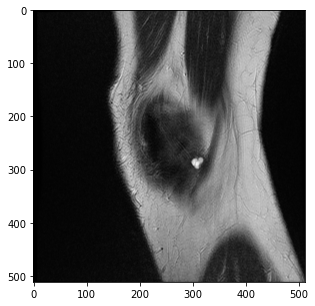

In [27]:
DicomV=DicomView()
DicomV.ShowDicomTable()

## Segmentation

We will now segment the bone only (brightest pixels). In this example we will segment our image into two regions simply dividing them by intensity values. The dark pixels will be in a region called **1**, the lighter pixels will be in **2**. We will perform this segmentation using thresholding.

Text(0.5, 1.0, 'Segmented Mask')

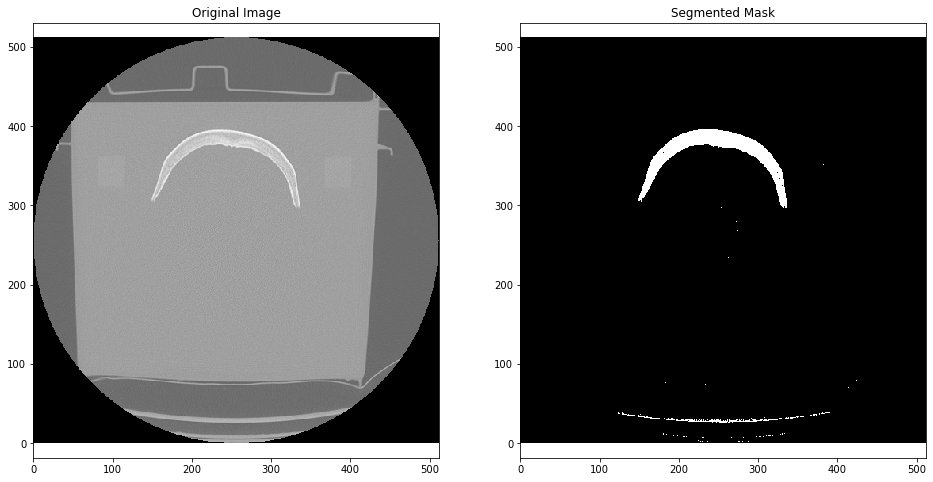

In [28]:
Threshold = 1300

mask = np.zeros_like(ArrayDicom,'uint8')
mask[ArrayDicom <= Threshold] = 0          
mask[ArrayDicom > Threshold] = 1

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.pcolormesh(np.flipud(ArrayDicom))
plt.axis('equal') #this makes the image square
plt.title('Original Image')
plt.subplot(122)
plt.pcolormesh(np.flipud(mask))
plt.axis('equal') #this makes the image square
plt.title('Segmented Mask')

This simple segmentation is effective but we have detected regions other than the bone, so we will need to separate regions so we can obtain the calculations only for the bone.

Text(0.5, 1.0, 'Segmented Mask Regions out of 77 regions detected')

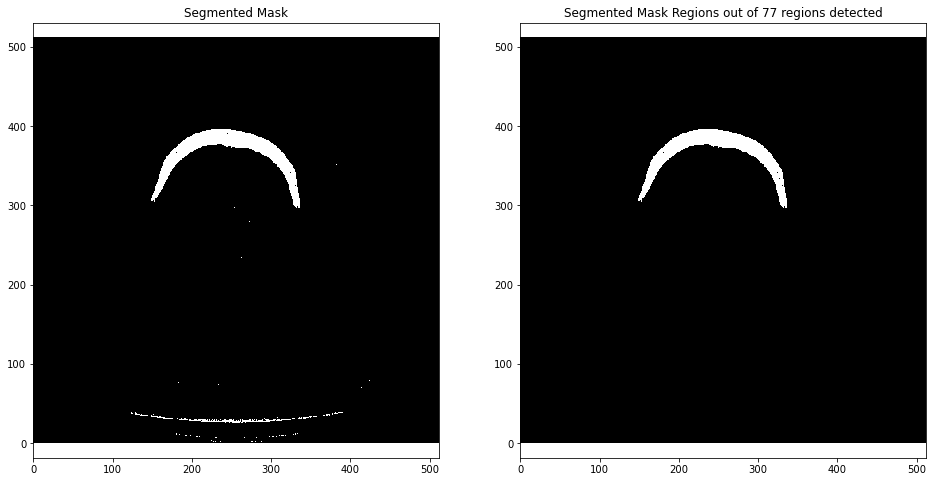

In [29]:
import cv2

plt.figure(figsize=(16, 8))
ret, markers = cv2.connectedComponents(mask)  #this will detect all the regions within the mask
# to determine which of the regions has the highest number of pixels we can use a histogram
hist,bins = np.histogram(markers.flatten(),ret,[0,ret])
# the highest number of pixels are evidently on the black, so we look for the second highest
inxhist=np.argsort(hist)  #indexes of the sorted histogram
inxbone=inxhist[-2]  #this is the index of the second last region (the last being the most frequent)
ROI=np.zeros_like(ArrayDicom,'uint8')
ROI[np.where(markers==inxbone)]=1   #we turn to 1 only those pixels that are in that second most frequent region

plt.subplot(121)
plt.pcolormesh(np.flipud(mask))
plt.axis('equal') #this makes the image square
plt.title('Segmented Mask')
plt.subplot(122)
plt.pcolormesh(np.flipud(ROI))
plt.axis('equal') #this makes the image square
plt.title('Segmented Mask Regions out of '+str(ret)+' regions detected')

### Activity 2 - Modify the markers array in the code above to have an array with only the 5 regions with the most pixels (other than the background), then make each region have a different color and plot. 

Tip: there are many solutions, but you can use *plt.imshow(ARRAY,cmap=cm.hot)* which will need *import matplotlib.cm as cm* so you can visualize the 5 regions. Note you can use a different map but this tip is for HOT.

In [30]:
# Enter the code for Activity 2
# HERE



We will now use that mask to obtain the intensities in the original image for the detected region and convert into HU. Then obtain the average density for that bone.

Text(0.5, 1.0, 'Segmented Image - HU: Average is -5.594777127420081 HU')

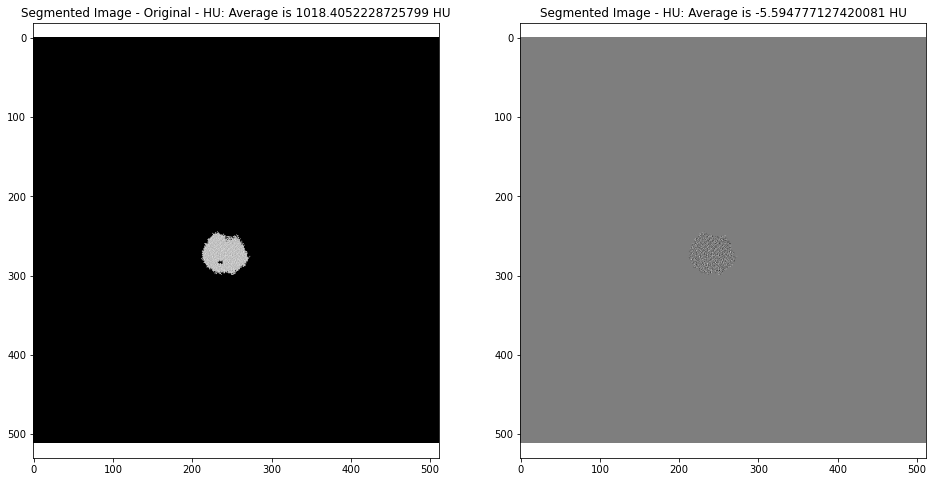

In [39]:
# We will first convert all the image to HU
CorrectedImage=RefDs.RescaleSlope*ArrayDicom+RefDs.RescaleIntercept
# Then obtain only the segmented Image in HU
SegmentedIm=ROI*CorrectedImage
SegmentedImNonCorrected=ArrayDicom*ROI
# And obtain an array of those intensities
intensity = SegmentedIm[np.where(ROI==1)] #Creating an array that contain only the bone pixels
intensityNonCorrected = SegmentedImNonCorrected[np.where(ROI==1)] #Creating an array that contain only the bone pixels before correction
# Now the average of that array is the average HU for the region
AvDensity=np.mean(intensity)    # CODE TO CHANGE FOR CHALLENGE 9
AvDensityNonCorrected=np.mean(intensityNonCorrected)

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(SegmentedImNonCorrected)
plt.axis('equal') #this makes the image square
plt.title('Segmented Image - Original - HU: Average is '+str(AvDensityNonCorrected)+' HU')
plt.subplot(122)
plt.imshow(SegmentedIm)
plt.axis('equal') #this makes the image square
plt.title('Segmented Image - HU: Average is '+str(AvDensity)+' HU')


For bone we expect a value between 700 and 3000 HU. For a skull we expect around 800 HU in average. Either method gives a value within the ranges for bone, but the correction does give a value that is closer to the expected density for skull bone.

## Volume Segmentation

We have already segmented one of the images here. We will code now a segmentation algorithm for all the images that were obtained with this CT and create a 3D array of the bone.

The segmentation before with automatic determination of the region with the bone using the second largest region will not work for all the images in the series. This is because the first images will have a very low amount of bone (first slices).

Because we observe that the bone is in the top part of the image we will first eliminate anything on the bottom and then run the segmentation for all images.

Text(0.5, 1.0, 'Segmented Mask')

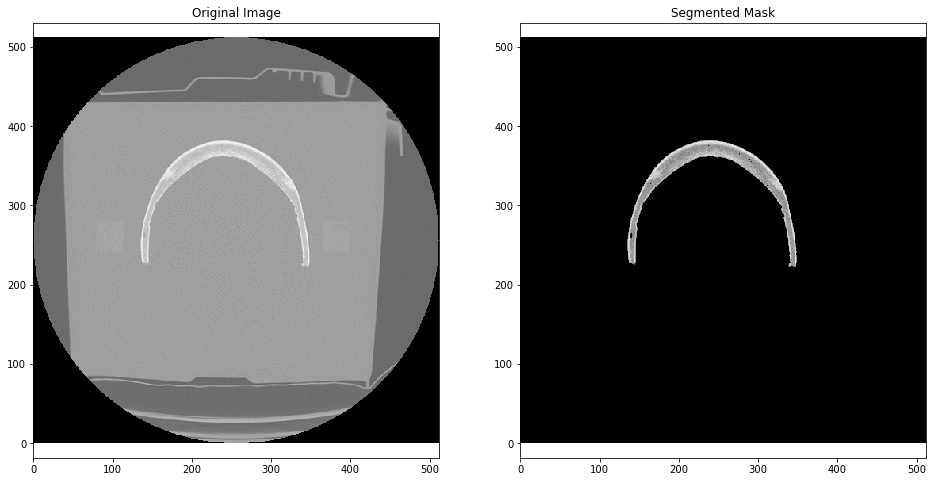

In [32]:
InFile=57
FinalFile=241
IndexBottom=400

fname='Source Files/CT_DICOMs/im{:d}'.format(100)
RefDs = pydicom.read_file(fname)
ArrayDicom3D = np.zeros((FinalFile-InFile+1,RefDs.Rows,RefDs.Columns), dtype=RefDs.pixel_array.dtype)
SegmentedArrayDicom3D = np.zeros((FinalFile-InFile+1,RefDs.Rows,RefDs.Columns), dtype=RefDs.pixel_array.dtype)

for ix in range(InFile,FinalFile+1):
    # Get file
    fname='Source Files/CT_DICOMs/im{:d}'.format(ix)
    RefDs = pydicom.read_file(fname)
    # Finally we had already read the file and we have the image information in the pixel_array (final field)
    ArrayDicom3D[ix-InFile,:,:]=RefDs.pixel_array

Threshold = 1300

mask3D = np.zeros_like(ArrayDicom3D,'uint8')
mask3D[ArrayDicom3D <= Threshold] = 0          
mask3D[ArrayDicom3D > Threshold] = 1
mask3D[:,IndexBottom:512,0:512] = 0   #this eliminates the bottom of the image

TotImages=len(ArrayDicom3D[:,1,1])

for ix in range(0,TotImages):
    ret, markers = cv2.connectedComponents(mask3D[ix])  #this will detect all the regions within the mask
    #plt.imshow(mask3D[ix])    #uncomment this line and the next if you want to see all the masks
    #plt.show()
    # to determine which of the regions has the highest number of pixels we can use a histogram
    hist,bins = np.histogram(markers.flatten(),ret,[0,ret])
    # the highest number of pixels are evidently on the black, so we look for the second highest
    inxhist=np.argsort(hist)  #indexes of the sorted histogram
    inxbone=inxhist[-2]  #this is the index of the second last region (the last being the most frequent)
    ROI=np.zeros_like(ArrayDicom3D[ix],'uint8')
    ROI[np.where(markers==inxbone)]=1   #we turn to 1 only those pixels that are in that second most frequent region
    SegmentedArrayDicom3D[ix,:,:]=ROI*ArrayDicom3D[ix,:,:]   #segmenting the image only to bone
    
SegmentedArrayDicom3D=RefDs.RescaleSlope*SegmentedArrayDicom3D+RefDs.RescaleIntercept  # Conversion to HU

#You can visualize one of the images changing the value here
VisImage=90

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.pcolormesh(np.flipud(ArrayDicom3D[VisImage]))
plt.axis('equal') #this makes the image square
plt.title('Original Image')
plt.subplot(122)
plt.pcolormesh(np.flipud(SegmentedArrayDicom3D[VisImage]))
plt.axis('equal') #this makes the image square
plt.title('Segmented Mask')

## Filtering

We will finally see the effects of filtering on the image and we will work on the segmented bone. As done before, we will use a high pass filter but we will also implement a low pass filter.

To smooth an image (low pass) we will try here a **Gaussian filter**. It achieves filtering by convolving the image with a kernel of Gaussian values which will do a Gaussian averaging of pixels. We can use the *gaussian_filter* funtion implemented in *scipy* where the dimension of the matrix for this convolution is defined.

We used a **Sobel** filter to enhance the edges (high pass). There are other high pass filters that can be used for sharpening images sugh as **Laplacian**. The Laplacian filter performs a 2nd spatial derivative of an image and thus enhances rapid intensity change which is also an edge detection method or a high pass filter. The Laplacian is very effective when an image was smoothed by averaging which is a common blurring effect on images. We can use the *laplace_filter* funtion implemented in *scipy* where the dimension of the matrix for this convolution is defined.

Text(0.5, 1.0, 'Original Image Sobel filtered - High Pass')

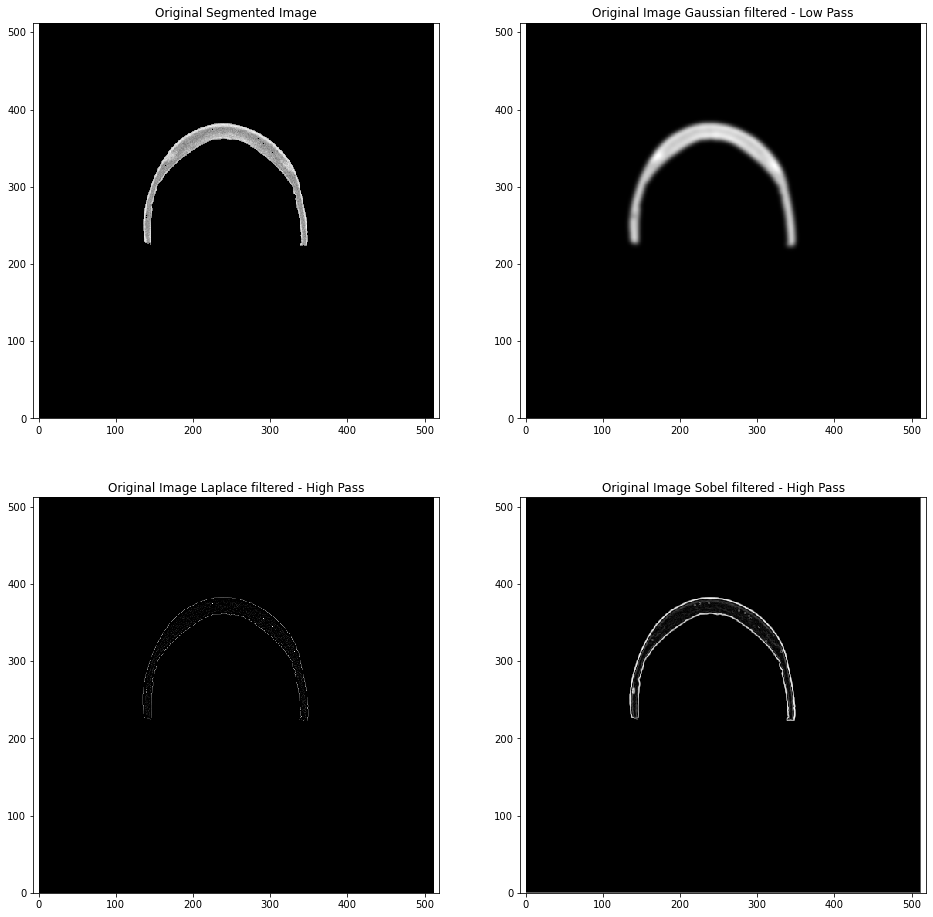

In [33]:
from scipy import ndimage

# LOW Pass
# Gaussian filter to smooth the image
ImageGaussian=ndimage.gaussian_filter(SegmentedArrayDicom3D[VisImage], sigma=3)

# HIGH PASS
# From the previous implementation of the Sobel filter
ImageSobelFx=ndimage.sobel(SegmentedArrayDicom3D[VisImage],axis=0, mode='constant')
ImageSobelFy=ndimage.sobel(SegmentedArrayDicom3D[VisImage],axis=1, mode='constant')
ImageSobelF=np.hypot(ImageSobelFx, ImageSobelFy)
# And the Laplace filter
ImageGaussianLaplace=ndimage.laplace(SegmentedArrayDicom3D[VisImage])
ImageGaussianLaplace[np.where(ImageGaussianLaplace<0)]=0

plt.figure(figsize=(16, 16))
plt.subplot(221)
plt.pcolormesh(np.flipud(SegmentedArrayDicom3D[VisImage]))
plt.axis('equal') #this makes the image square
plt.title('Original Segmented Image')
plt.subplot(222)
plt.pcolormesh(np.flipud(ImageGaussian))
plt.axis('equal') #this makes the image square
plt.title('Original Image Gaussian filtered - Low Pass')
plt.subplot(223)
plt.pcolormesh(np.flipud(ImageGaussianLaplace))
plt.axis('equal') #this makes the image square
plt.title('Original Image Laplace filtered - High Pass')
plt.subplot(224)
plt.pcolormesh(np.flipud(ImageSobelF))
plt.axis('equal') #this makes the image square
plt.title('Original Image Sobel filtered - High Pass')

### Activity 3 - Modify the size of the Gaussian filter and make observations on the resulting image.

**Write your observations after modifying the Gaussian filter here**



In [34]:
# Add the code with the modified Gaussian filter
# HERE



### Activity 4 - Add in the cell below code to obtain an image where a low pass filter followed by a high pass filter is done, and showing the original image, the low pass filtered image, and the low and high pass filtered image. Make observations on the resulting image.

**Add your observations here**

In [35]:
# Add your code for Activity 4
# HERE



## 3D Rendering

We will finally make a volumetric rendering of this image. For this, we need to generate a mesh of triangles and vertices out of our segmented data. 

An algorithm that is widely used for this purpose is the **marching cubes**. This algorithm extracts a polygonal mesh of an isosurface from a three-dimensional discrete scalar field (our 3D mask). It is widely used for visualizations of CT and MRI scans.

The algorithm uses eight contigous pixels locations at a time to form a cube (each pixel is a vertix) and determines which of the possible series of polygons within this cube is the most appropriate depending on the pixel being on or off. 


| $~$ |
|:---: |
| <img src="Figures/MarchingCubes.jpg" width=380> |


Finally each vertex of the generated polygons is placed on the appropriate position along the edge by linearly interpolating the two scalar values obtained for the neighbouring cubes.

This algorithm has been implemented in *skimage*.

In [36]:
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from ipywidgets import interact_manual, interact

def make_mesh(image, threshold=5, step_size=1):
    p=image
    # generation of the vertices and faces of polygons using marching cubes
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

In [37]:
def plt_3d(verts, faces, orientationX, orientationY):
 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    x,y,z = zip(*verts) 
        
    # verts[faces] generates a collection of triangles which is needed by Poly3DCollection
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    
    face_color = [0.89, 0.85, 0.79]    #bone colour
    mesh.set_facecolor(face_color)    
    mesh.set_edgecolor([0,0,0])    #black
    ax.add_collection3d(mesh)    #creates the volume image

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    
    ax.view_init(orientationX, orientationY)   #sets the orientation of the view
    
    plt.show() 

/tmp/ipykernel_120/2061672948.py:8: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, step_size=step_size, allow_degenerate=True)


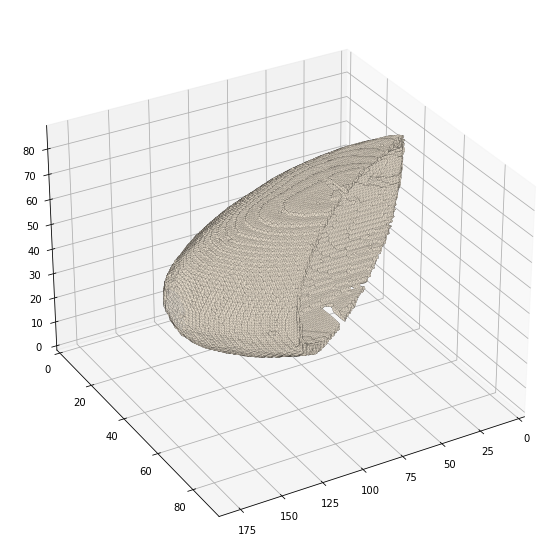

In [38]:
ImageforVolumeRendering=SegmentedArrayDicom3D[:,::4,::4]

verts, faces = make_mesh(ImageforVolumeRendering, 350)   #calls function to create mesh
plt_3d(verts, faces, 30,60);   #calls function to plot and opens a pager with execution information

### Activity 5 - Analyze the code above and answer the question: What is the *ImageforVolumeRendering=SegmentedArrayDicom3D[:,::4,::4]* code line doing? Why do you think this is needed?

**Type your answer here.**




## Summary

In this example we:

* Showed how to open and inspect a DICOM image from a CT scan
* Obtained the adjusted information for density in Hounsfield Units from the intensity of pixels in the CT scan
* Segmented the bone fron a CT image and obtained the average density 
* Performed segmentation over the whole CT volume acquired and rendered a 3D image
* Filtered the CT image using a low and high pass filter
* Made a simplification on the volumetric data for faster 3D rendering

Comments and corrections welcome!

## Assignment 5

* Complete the 5 Activities in the notebook and upload your notebook to your GitHub repository.
* Remember you should have given permissions to this **private** repository to your instructor.
* Please note you should upload all your code in the repository with those permissions, do not give permissions every time for new repositories.
* Submit on D2L the PDF of your notebook where the results of these activities can be seen. The backup PDF accounts for 10% of your mark. Note that full marks are only given if the code is on your repository and runs, but you can get partial marks from this PDF output if the code fails to run or is not accessible at the time of grading. No marks will be given if the date on GitHub is after the deadline.
* The following challenges **are for bonus points** and you can submit them later (up until the final exam date) 

# Challenge \# 9

In the code where we have obtained the average of the HU we used a mask and using numpy .mean (see the comment #CODE for challenge 9)
There is an implementation possible using scipy that can directly create the labels and we can then obtain the mean for each of the labels.

Implement that code using scipy to obtain both the labels and the mean.

In [40]:
# Add your code for Challenge 9 here


References
---------------

* Tinku Acharya and Ajoy K. Ray, *Image Processing - Principles and Applications*. Wiley InterScience, 2006.
* https://docs.scipy.org
* Laprairie, Mark JW, and Howard J. Hamilton. "Isovox: A Brick-Octree Approach to Indirect Visualization."